# Applying GrandPrix on the single cell RNA-seq of mouse dendritic cells
_Sumon Ahmed_, 2017

This notebooks shows how GrandPrix with informative prior over the latent space can be used to infer one dimensional pseudotime from the single cell RNA-seq of the primary bone-marrow-derived dendritic cells of mouse.

In [3]:
import pandas as pd
import numpy as np
from GrandPrix import GrandPrix
from utils import plot, plot_fitting_time_comparison
%matplotlib inline

## Data description

<a href="https://www.ncbi.nlm.nih.gov/pubmed/24919153" target="_blank">Shalek et al. (2014)</a> generated single cell RNA-seq from the primary bone-marrow-derived dendritic cells of mouse in three different conditions.They described
several modules of genes which show different temporal expression patterns through the lipopolysaccharide stimulated (LPS) time course.

They found two cells captured at the 1 hour mark which switched to this group precociously, i.e. have genes expressed which are not expressed in the other cells of the 1 hour group.

The "ShalekTrainingData.csv" file contains the expression profiles of the top 74 variable expressed genes in 307 cells from the LPS time course which have been used in the inference.

The "ShalekCellMeta.csv" file contains the additional information of the data such as capture time of each cells, different initializations of pseudotimes, etc.

In [4]:
Y = pd.read_csv('data/Shalek/ShalekTrainingData.csv', index_col=[0]).T.values
mData = pd.read_csv('data/Shalek/ShalekCellMeta.csv', index_col=[0])

In [5]:
from sklearn import preprocessing
Y = preprocessing.scale(Y)
N, D = Y.shape

In [6]:
mData.head()

,c,cell,assay,ko,stimulant,captureActual,replicate,cell.num,obstime,total,...,init_11,init_12,init_13,init_14,init_15,init_16,init_17,init_18,init_19,init_20
1,1,Unstimulated_S15,NaN,NaN,NaN,Unstimulated,NaN,15,0,8930811,...,0.176471,4.124183,3.183007,-0.686275,-0.320261,-0.529412,2.764706,0.202614,-0.686275,-0.686275
2,2,Unstimulated_S16,NaN,NaN,NaN,Unstimulated,NaN,16,0,8438017,...,-0.450980,1.352941,3.000000,-0.555556,-0.790850,-0.921569,3.549020,-0.294118,0.098039,0.437908
3,3,Unstimulated_S17,NaN,NaN,NaN,Unstimulated,NaN,17,0,8517120,...,-0.346405,1.379085,3.810458,-0.764706,0.254902,-0.738562,3.026144,-0.163399,2.032680,0.098039
4,4,Unstimulated_S23,NaN,NaN,NaN,Unstimulated,NaN,23,0,5975840,...,-0.764706,-0.346405,3.679739,-0.032680,0.228758,-0.450980,3.784314,-0.581699,0.437908,2.032680
5,5,Unstimulated_S24,NaN,NaN,NaN,Unstimulated,NaN,24,0,11633075,...,-0.921569,-0.450980,2.895425,-0.398693,-0.006536,-0.346405,2.163399,-0.686275,1.169935,1.169935


## Model Construction
The first step of using the GrandPrix is to initialize the model with the observed data and the additional metadata (optional).

In [7]:
mp = GrandPrix(Y, mData)

### Build sparse Bayesian GPLVM model
Following initializations are essential for better optimizations. If not initialized, the default values will be used.  
<ul>
<li>__kernel:__ Covariance function to define the mappring mapping from the latent space to the data space in Gaussian process prior. 
<!--
    <ul>
        <li>name</li>
        <li>ls</li>
        <li>var</li>
        <li>period</li>
    </ul>
-->
</li>

<li>__vParams:__ Variational Parameters
    <ul>
        <li>Xmean - mean of the latent dimensions. 
        
        ndarray of size $N \times Q$.</li>
        <li>Xvar - variance over the latent dimensions. A single floating point value or a ndarray of size $N \times Q$.</li>
        <li>Z - inducing inputs. ndarray of size $M \times Q$.</li>
    </ul>
</li>
<li>__priors:__ Prior over the latent input dimensions
    <ul>
        <li>Priormean - mean of the prior distribution. ndarray of size $N \times D$.</li>
        <li>Priorvar - variance of the prior distribution. A floating point value or a ndarray of size $N \times D$.</li>
    </ul>
</li>

<li>__latent_dims:__ Number of latent dimensions. An integer.</li>
<li>__n_inducing_points:__ Number of inducing points. An integer.</li>
</ul>

In [8]:
latent_dims = 1
n_inducing_points = 30

np.random.seed(10)
sigma_t = 1.
prior_mean = mData['capture.orig'].values[:, None]

X_mean = [prior_mean[i, 0] + sigma_t * np.random.randn(1) for i in range(0, N)]   

np.random.seed(10)
Z = np.random.rand(n_inducing_points, latent_dims)

priors = {'Priormean':prior_mean, 'Priorvar':np.square(sigma_t)}
vParams = {'Xmean':np.asarray(X_mean), 'Z':Z}

In [9]:
mp.build_model(priors, vParams, kernel={'name':'Matern32', 'ls':5.0, 'var':1.0}, n_inducing_points = 30)

### Run the model
- `fit_model` optimizes the model.
- `get_pseudotime` returns the estimated pseudotime points.

In [10]:
mp.fit_model()

In [11]:
pseudotimes = mp.get_pseudotime()

## Visualize the results
The module score <a href="https://www.ncbi.nlm.nih.gov/pubmed/24919153" target="_blank" style="text-decoration:none">(Shalek et al., 2014)</a> of core antiviral genes have been plotted over the estimated pseudotimes. Each point corresponds to the module score of a cell. 

The points are coloured according to the actual cell capture time.

A Loess curve through the data have been generated by using the R `stat_smooth` function. 

In [12]:
data = pd.DataFrame({'Pseudotime':pseudotimes.reshape(-1), 'Module_score':mData['module.score'], 
                     'capture':mData['obstime'].values, 'type':mData['Precocious'].values})
data=data.sort('type', ascending=True)

In [13]:
import readline
import rpy2.robjects
%load_ext rpy2.ipython

In [14]:
%%R
library(ggplot2)

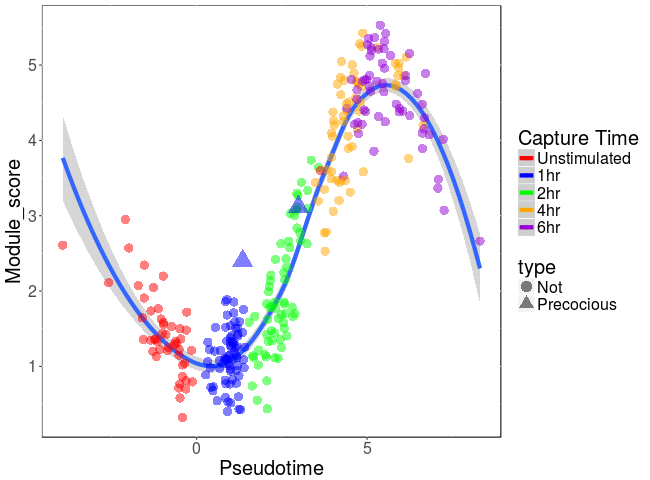

In [15]:
%%R -i data -w 650
head(data)

plots1<-(
    ggplot(data,
           aes(x=Pseudotime, y=Module_score, color=as.factor(capture), shape=type, size=type=='Precocious'))
    + stat_smooth(aes(group="", color=NULL), size=2)
    + scale_size_manual(values=c(4, 7))
    + theme(panel.background = element_rect(fill="white", linetype="solid", color="black"))
    + theme(text = element_text(size=20))
)
plots1 = plots1 + geom_point(alpha=0.5) + scale_colour_manual(name = 'Capture Time', 
         values =c('0'='red','1'='blue','2'='green','4'='orange','6'='darkviolet'), 
                                      labels = c('Unstimulated','1hr','2hr','4hr','6hr'))
plots1 = plots1 + guides(size=FALSE, shape = guide_legend(override.aes = list(size=5)))
print(plots1)

## Comparison to the <a href="https://github.com/JohnReid/DeLorean" target="_blank" style="text-decoration:none;"> DeLorean Model</a>
* $20$ different initializations have been used
* Models have been compared for varying number of inducing points in terms of the fitting times required 

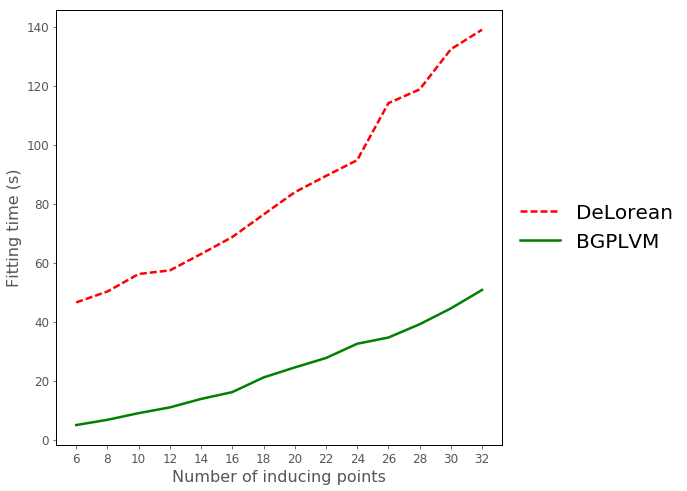

In [16]:
plotDf = pd.read_csv('data/Shalek/ShalekComparison.csv', index_col=[0])
plot_fitting_time_comparison(plotDf)

### The following code will regenerate the comparison result 
- The code uses 20 different initial conditions from ShalekMetaData.csv file.

Runnig the following code will take a long time.

In [17]:
u = [6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]
keys = mData.keys()
rows = len(u)
cols = len(keys) - 18
# cols = 4

reqTime = np.zeros((rows, cols))

for i in range(0, rows):
    for j in range(0, cols):
        np.random.seed(10)
        Z = np.random.rand(u[i], latent_dims)
        vParams = {'Xmean':keys[j + 18], 'Z':Z}
        mp.build_model(priors, vParams, kernel={'name':'Matern32', 'ls':5.0, 'var':1.0}, n_inducing_points=u[i], fixed=('Z', 'X_var', 'k_ls', 'k_var'))
        mp.fit_model()
        reqTime[i,j] = mp.get_model_fitting_time()

avgReqTime = [np.mean(reqTime[n]) for n in range(0, rows)]
plotDf['GPLVM_fitting_time'] = avgReqTime

In [17]:
plot_fitting_time_comparison(plotDf)